# AIRDOS04

In [181]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import re

#directory = './data/' # Directory with data 
directory = '/storage/experiments/2024/10_Albanie_Armenie/AIRDOS/EVN-WAW-PRG' # bourka cestou z Armenie 2024

FIRST_CHANNEL = 8 # a column of the 1st channel without noise
ZERO_CHANNEL = 4 # a column of the channel with maximal noise
CH_WIDTH = 0.0066 # [MeV]

In [182]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

df=pd.DataFrame()

sn = '0'
files = sorted(glob.iglob(directory + '/*.TXT'), key=numericalSort)
for file in files:
    print(file)
    l=[]
    l.extend(range(0,1028))
    f = pd.read_csv(file, sep=',', header=None, names=l, comment='*', low_memory=False)
    try:
        sn = f.loc[f[0]=='$DOS'].iloc[0,6]
        print("S.N.: ", sn)
    except:
        pass
    df = pd.concat([df,f], ignore_index=True)

#df = df.reset_index(drop=True)
print('All files was readed.')

/storage/experiments/2024/10_Albanie_Armenie/AIRDOS/EVN-WAW-PRG/89.TXT
S.N.:  1290c00806a200923049a000a00000c5
All files was readed.


In [183]:
run = 0
df['run'] = np.nan
df = df.loc[df[0]=='$HIST'].copy()
df[2] = pd.to_numeric(df[2], errors='coerce')

df[1] = pd.to_numeric(df[1], errors='coerce')

try:
    for x in df.loc[df[1]<20].index:
        df.loc[x,'run'] = run
        run += 1
except:
    pass
df['run'].fillna(method="ffill", inplace=True)

df['sum'] = df.iloc[:,FIRST_CHANNEL:1028].sum(axis=1)
df['mean'] = df['sum'].rolling(30).mean()


In [184]:
SELECTED_RUN = 19 # Measurement run (order of power on)
FROM = 3075.0 # Start time in hour
TO = 3079.5 # Stop time in hour

0.033 0.0066


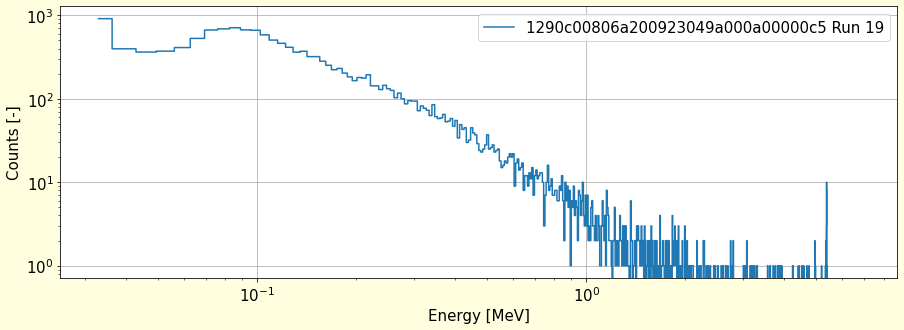

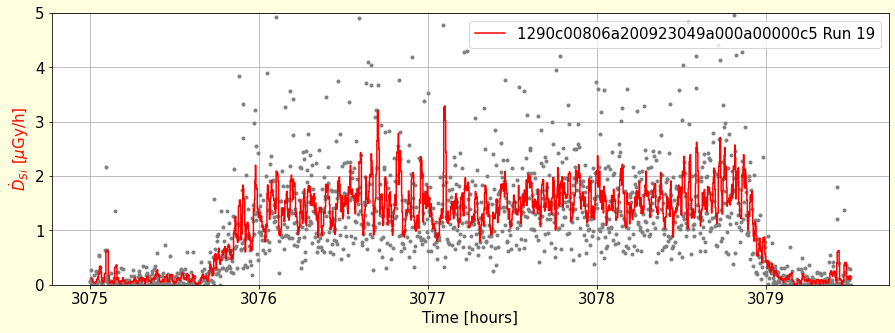

In [185]:
WINDOW = 5

coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print(coef[0], coef[1])

r = SELECTED_RUN
rc = df.loc[df['run']==SELECTED_RUN].loc[df[2]>=FROM*3600].loc[df[2]<=TO*3600].copy()
rc[2] = pd.to_numeric(rc[2], errors='coerce')

plt.figure(figsize=(15,5), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})

ener = rc.iloc[:,FIRST_CHANNEL:1028].sum()

e = pd.DataFrame()
e['1'] = ener
e['i'] = ener.index
e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]

plt.plot(e['x'], e['1'], drawstyle='steps-mid', label=sn+' Run '+str(r))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts [-]')
plt.grid()

plt.legend()
plt.show()


rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:1028]) * np.asarray(e['x'])).sum(axis=1)    

# size of the chip (20 mm · 10 mm), 
# the thickness of the depletion layer (0.3 mm), 
# and the density of silicon (2.33 g cm^3)
# 0.1165e-3 kg
rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

rc['dsimean'] = rc['dsi'].rolling(WINDOW).mean()

plt.figure(figsize=(15,5), facecolor='lightyellow')
matplotlib.rcParams.update({'font.size': 15})
plt.plot(rc[2]/3600,rc['dsi'], c='gray', linestyle='', marker='.')
plt.plot(rc[2]/3600,rc['dsimean'],c='red', drawstyle='steps-mid', label=sn+' Run '+str(r))

plt.ylim([0,5])

plt.xlabel('Time [hours]')
plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
plt.legend(loc=1)

plt.grid()
plt.show()


In [186]:
flight_radar_file = '/storage/experiments/2024/10_Albanie_Armenie/AIRDOS/EVN-WAW-PRG/LO730_3797fca2.csv' # bourka cestou z Armenie 2024

dffr = pd.read_csv(flight_radar_file, header=None, skiprows=1, comment='*', on_bad_lines='skip', engine='python',index_col=False)

dffr.rename(columns={4: 'altitude'}, inplace=True)
dffr[['lat', 'lon']] = dffr[3].str.split(',', expand=True)
dffr['altitude'] = dffr['altitude'] * 0.3048

dffr['lat'] = pd.to_numeric(dffr['lat'])
dffr['lon'] = pd.to_numeric(dffr['lon'])
#df6['altitude'] = pd.to_numeric(df6['altitude']) * 1000


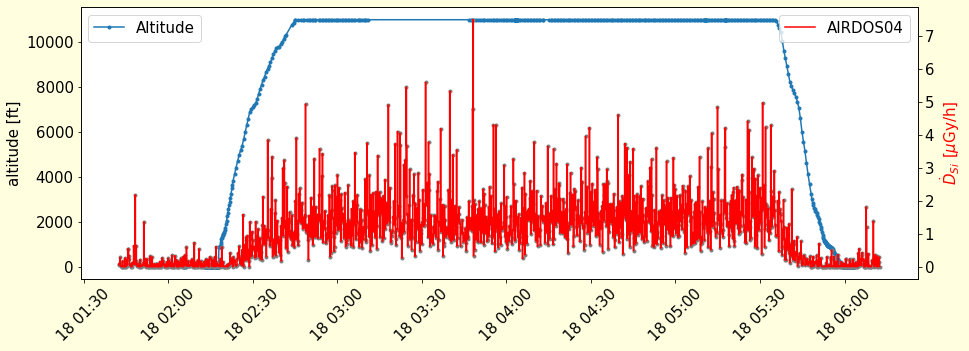

In [192]:
plt.figure(figsize=(15,5), facecolor='lightyellow')

dffr['time']=pd.to_datetime(dffr[1])
dffr = dffr.set_index(dffr['time'])

plt.plot(dffr['altitude'], marker='.', label='Altitude')
plt.ylabel('altitude [ft]')
plt.xticks(rotation=45)
plt.legend(loc=2)

#plt.vlines(pd.to_datetime('2024-10-18 03:34:00'),1000,12000)
#plt.vlines(pd.to_datetime('2024-10-18 03:08:00'),1000,12000)

#plt.xlim(pd.to_datetime('2024-10-18 03:34:00'),pd.to_datetime('2024-10-18 03:08:00'))
#plt.xlim(pd.to_datetime('2024-10-18 03:34:00'),pd.to_datetime('2024-10-18 04:00:00'))
#plt.xlim(pd.to_datetime('2024-10-18 03:30:00'),pd.to_datetime('2024-10-18 03:50:00'))

plt.twinx()

rc['time'] = pd.to_datetime('2024-10-18 01:42:30') + pd.to_timedelta(rc.iloc[:,2] - rc.iloc[0,2], 'seconds')
rc.set_index('time', inplace=True, drop=False)

plt.plot(rc['dsi'], c='gray', linestyle='', marker='.')
#rcr = rc.resample('1T').mean()
rcr = rc
plt.plot(rcr['dsi'],c='red', drawstyle='steps-mid', label='AIRDOS04')
#plt.ylim(0,4)
plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
plt.legend(loc=1)

None

<Figure size 1080x360 with 0 Axes>

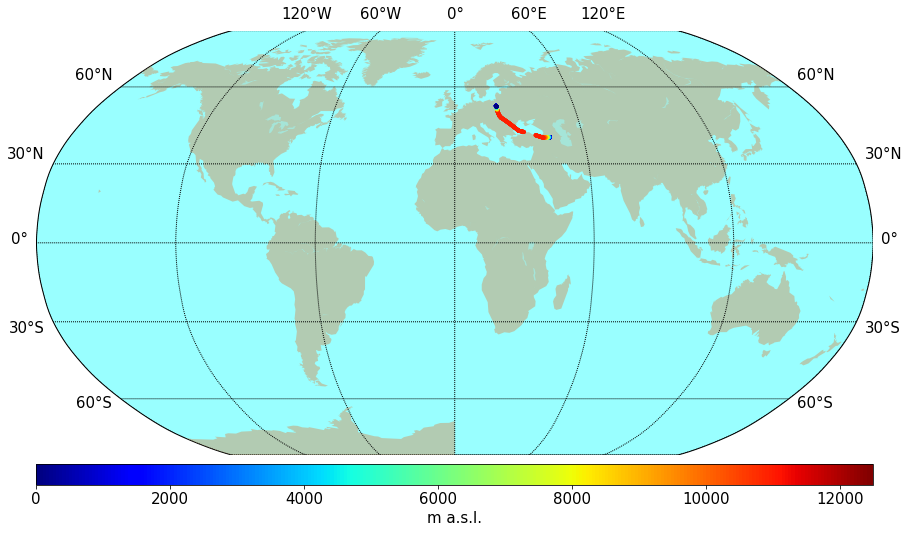

In [193]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib

plt.figure(figsize=(15,5))
plt.tight_layout()
df6 = dffr

plt.figure(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
#m = Basemap(projection='cea',lon_0=0)
m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(df6.lon.tolist(),df6.lat.tolist())

m.drawmapboundary(fill_color='#99ffff')
m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0, alpha=0.5)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])

im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='.', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#s = f.split('/')
#plt.title(s[len(s)-1], pad=50)

plt.clim(0, 12500)  # limit for color axis
plt.show()                


In [194]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()
import matplotlib.colors as colors


hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

In [134]:
sitename = 'let z Armenie 2024'
lat=42.214241
lon=32.371647
start=pd.Timestamp('2024-10-18 3:00')
#start=pd.Timestamp('2024-10-18 4:00')
end=pd.Timestamp('2024-10-18 4:55')

print(start, end, lat, lon)
region=1
#region=18
#region=19
#region=4 # Asia

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    #url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))
    url.append('http://backup.blitzortung.org/Data/Protected/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        #html = requests.get(url[i]).content
        html = requests.get(url[i], auth=('meteopress', 'vactoV-bixso0-zohroq')).content
        blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz = pd.concat([blitz,blitz_part])
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

print('end')

2024-10-18 03:00:00 2024-10-18 04:55:00 42.214241 32.371647
end


In [195]:
# Reduction of distant lightnings

BLITZ_DIST = 1000

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['sig'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]

#blitz.to_csv('region19.csv')

No columns to drop (alt, pol, region)


/tmp/ipykernel_31529/4013223299.py:102: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc['2024-10-18 03:33:00':]
/tmp/ipykernel_31529/4013223299.py:106: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc['2024-10-18 04:26:40':]
/tmp/ipykernel_31529/4013223299.py:113: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  dfffr = dffr[pd.to_datetime('2024-10-18 03:00:00'):pd.to_datetime('2024-10-18 04:50:00')]
/tmp/ipykernel_31529/4013223299.py:116: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a

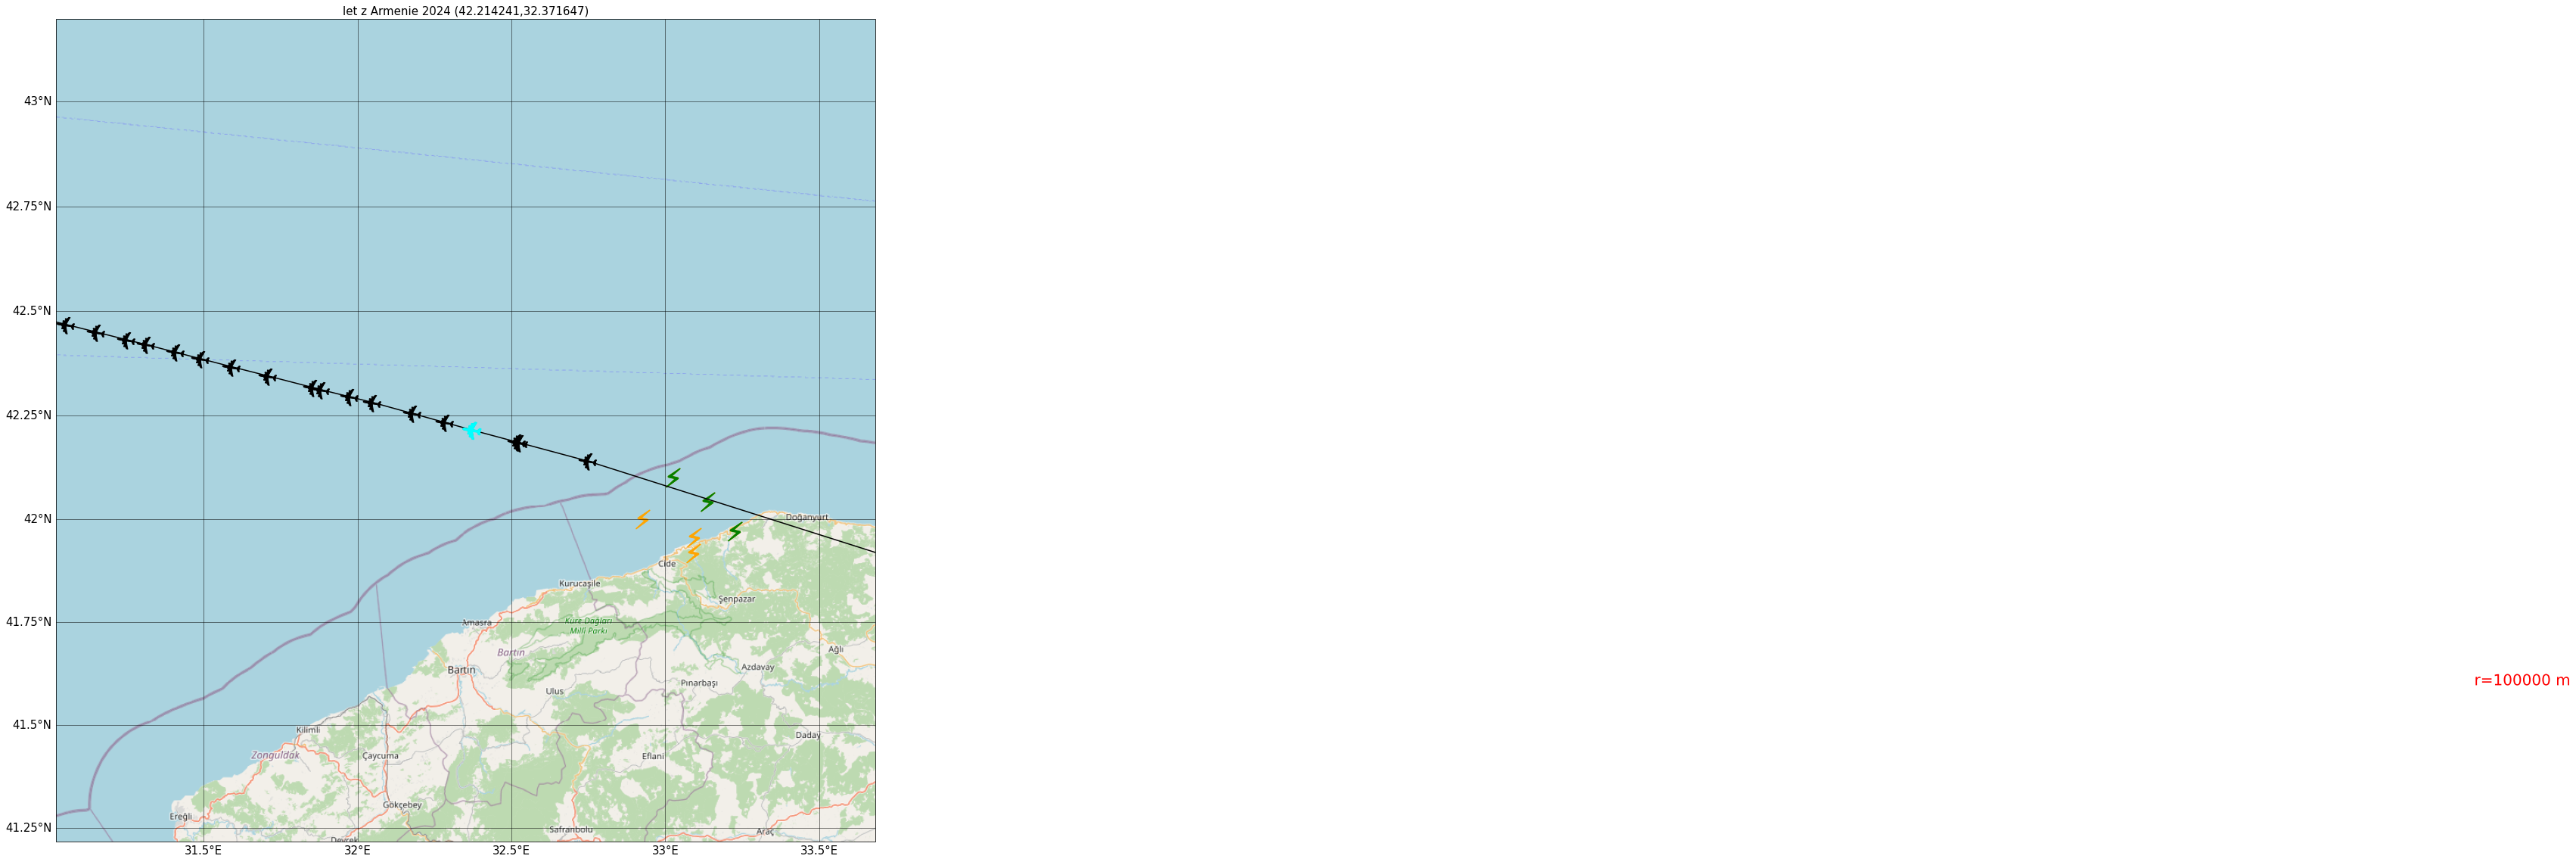

In [200]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    '''
    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3
    sitename = 'Kosetice'
    lat=49.5722392
    lon=15.0799906
    '''
    
    RADIUS = 100000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    lat=40.8113889
    lon=38.2808889
    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    lightning = blitz.loc['2024-10-18 03:33:00':]
    lightning = lightning.loc[lightning.lon<34.]
    ax.plot(lightning.lon,lightning.lat,color='orange',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)
    
    lightning = blitz.loc['2024-10-18 04:26:40':]
    lightning = lightning.loc[lightning.lon<34.]
    ax.plot(lightning.lon,lightning.lat,color='green',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)
        
    t = matplotlib.markers.MarkerStyle(marker='$\u2708$')
    t._transform = t.get_transform().rotate_deg(170)
    
    dfffr = dffr[pd.to_datetime('2024-10-18 03:00:00'):pd.to_datetime('2024-10-18 04:50:00')]
    ax.plot(dfffr.lon,dfffr.lat,marker=t, ms=25, color='black' ,transform=data_crs)
    
    dfffr = dffr[pd.to_datetime('2024-10-18 03:48:10'):pd.to_datetime('2024-10-18 03:49:00')]
    ax.plot(dfffr.lon,dfffr.lat,marker=t, ms=25, mew=2, color='cyan' ,transform=data_crs)

    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

/tmp/ipykernel_31529/3029614968.py:100: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc['2024-10-18 03:33:00':]
/tmp/ipykernel_31529/3029614968.py:108: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  lightning = blitz.loc['2024-10-18 04:26:40':]
/tmp/ipykernel_31529/3029614968.py:119: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  dfffr = dffr[pd.to_datetime('2024-10-18 03:00:00'):pd.to_datetime('2024-10-18 04:50:00')]
/tmp/ipykernel_31529/3029614968.py:122: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a

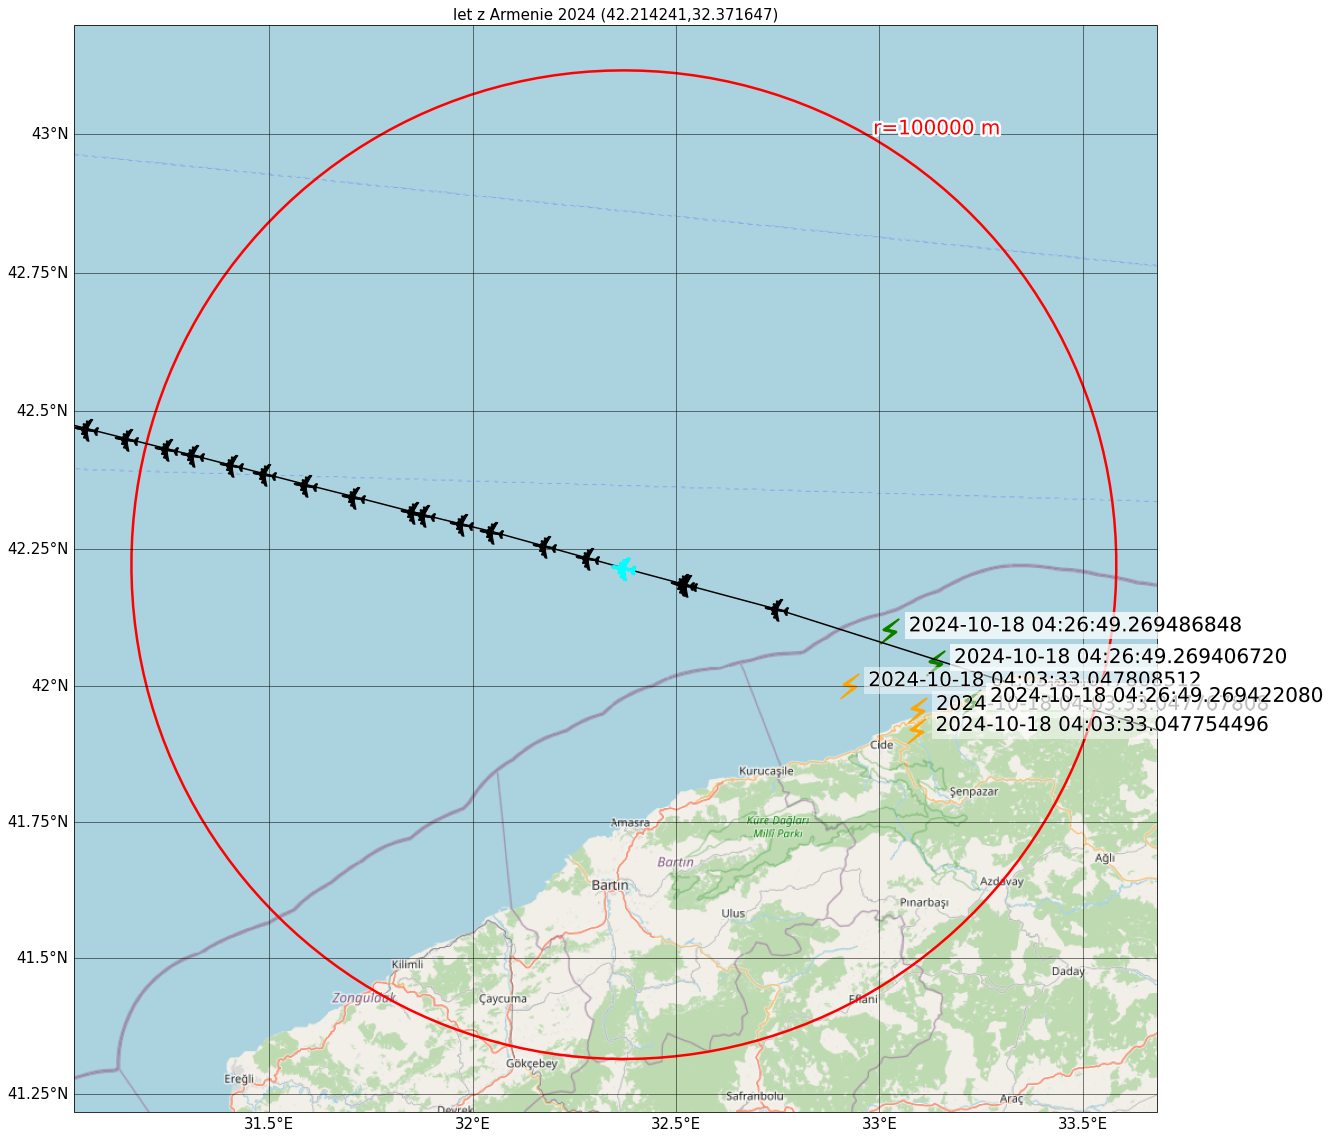

In [168]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    '''
    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3
    sitename = 'Kosetice'
    lat=49.5722392
    lon=15.0799906
    '''
    
    RADIUS = 100000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    #ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    #ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    lightning = blitz.loc['2024-10-18 03:33:00':]
    lightning = lightning.loc[lightning.lon<34.]
    ax.plot(lightning.lon,lightning.lat,color='orange',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)
    # Cas jednotlivych bodu
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.05, row.lat, pd.to_datetime(row.time, unit='ns'), color='black', fontsize=20, path_effects=stroke, transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))
    
    lightning = blitz.loc['2024-10-18 04:26:40':]
    lightning = lightning.loc[lightning.lon<34.]
    ax.plot(lightning.lon,lightning.lat,color='green',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)
    # Cas jednotlivych bodu
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.05, row.lat, pd.to_datetime(row.time, unit='ns'), color='black', fontsize=20, path_effects=stroke, transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))
        
    t = matplotlib.markers.MarkerStyle(marker='$\u2708$')
    t._transform = t.get_transform().rotate_deg(170)
    
    dfffr = dffr[pd.to_datetime('2024-10-18 03:00:00'):pd.to_datetime('2024-10-18 04:50:00')]
    ax.plot(dfffr.lon,dfffr.lat,marker=t, ms=25, color='black' ,transform=data_crs)
    
    dfffr = dffr[pd.to_datetime('2024-10-18 03:48:10'):pd.to_datetime('2024-10-18 03:49:00')]
    ax.plot(dfffr.lon,dfffr.lat,marker=t, ms=25, mew=2, color='cyan' ,transform=data_crs)

    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

In [199]:
dffr[pd.to_datetime('2024-10-18 03:33:00'):pd.to_datetime('2024-10-18 04:50:00')]

/tmp/ipykernel_31529/369852540.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  dffr[pd.to_datetime('2024-10-18 03:33:00'):pd.to_datetime('2024-10-18 04:50:00')]


,0,1,2,3,altitude,5,6,lat,lon,time
time,,,,,,,,,,
2024-10-18 03:46:43+00:00,1729223203,2024-10-18T03:46:43Z,LOT730,"42.139366,32.748116",10972.8,414,285,42.139366,32.748116,2024-10-18 03:46:43+00:00
2024-10-18 03:47:31+00:00,1729223251,2024-10-18T03:47:31Z,LOT730,"42.183739,32.525661",10972.8,412,284,42.183739,32.525661,2024-10-18 03:47:31+00:00
2024-10-18 03:47:39+00:00,1729223259,2024-10-18T03:47:39Z,LOT730,"42.185757,32.516479",10972.8,412,284,42.185757,32.516479,2024-10-18 03:47:39+00:00
2024-10-18 03:48:38+00:00,1729223318,2024-10-18T03:48:38Z,LOT730,"42.214241,32.371647",10972.8,412,284,42.214241,32.371647,2024-10-18 03:48:38+00:00
2024-10-18 03:49:15+00:00,1729223355,2024-10-18T03:49:15Z,LOT730,"42.232418,32.283154",10972.8,410,285,42.232418,32.283154,2024-10-18 03:49:15+00:00
...,...,...,...,...,...,...,...,...,...,...
2024-10-18 04:47:36+00:00,1729226856,2024-10-18T04:47:36Z,LOT730,"46.007854,25.397919",10972.8,398,312,46.007854,25.397919,2024-10-18 04:47:36+00:00
2024-10-18 04:48:07+00:00,1729226887,2024-10-18T04:48:07Z,LOT730,"46.045891,25.338318",10972.8,398,312,46.045891,25.338318,2024-10-18 04:48:07+00:00
2024-10-18 04:48:41+00:00,1729226921,2024-10-18T04:48:41Z,LOT730,"46.088203,25.271713",10972.8,398,312,46.088203,25.271713,2024-10-18 04:48:41+00:00


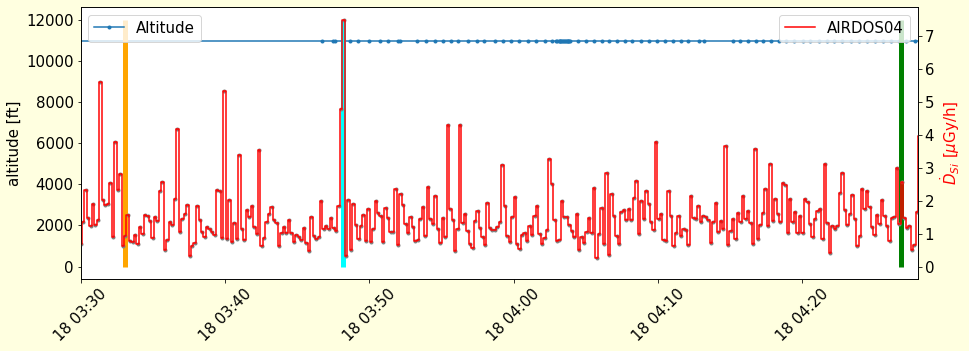

In [197]:
plt.figure(figsize=(15,5), facecolor='lightyellow')

dffr['time']=pd.to_datetime(dffr[1])
dffr = dffr.set_index(dffr['time'])

plt.plot(dffr['altitude'], marker='.', label='Altitude')
plt.ylabel('altitude [ft]')
plt.xticks(rotation=45)
plt.legend(loc=2)

plt.vlines(pd.to_datetime('2024-10-18 03:33:05'),0,12000, lw=5, color='orange')
plt.vlines(pd.to_datetime('2024-10-18 04:26:49'),0,12000, lw=5, color='green')
plt.vlines(pd.to_datetime('2024-10-18 03:48:10'),0,12000, lw=5, color='cyan')

#plt.xlim(pd.to_datetime('2024-10-18 03:34:00'),pd.to_datetime('2024-10-18 03:08:00'))
#plt.xlim(pd.to_datetime('2024-10-18 03:34:00'),pd.to_datetime('2024-10-18 04:00:00'))
plt.xlim(pd.to_datetime('2024-10-18 03:30:00'),pd.to_datetime('2024-10-18 04:28:00'))

plt.twinx()

rc['time'] = pd.to_datetime('2024-10-18 01:42:30') + pd.to_timedelta(rc.iloc[:,2] - rc.iloc[0,2], 'seconds')
rc.set_index('time', inplace=True, drop=False)

plt.plot(rc['dsi'], c='gray', linestyle='', marker='.')
#rcr = rc.resample('1T').mean()
rcr = rc
plt.plot(rcr['dsi'],c='red', drawstyle='steps-mid', label='AIRDOS04')
#plt.ylim(0,4)
plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
plt.legend(loc=1)

None

# LABDOS

In [170]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
import re

directory = '/storage/experiments/2024/10_Albanie_Armenie/LABDOS/EVN-WAW-PRG' # Directory with data 

FIRST_CHANNEL = 9 # a column of the 1st channel without noise
ZERO_CHANNEL = 5 # a column of the channel with maximal noise
CH_WIDTH = 0.013 # [MeV]

In [171]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

df=pd.DataFrame()

files = sorted(glob.iglob(directory + '/*.TXT'), key=numericalSort)
for file in files:
    print(file)
    l=[]
    l.extend(range(0,520))
    f = pd.read_csv(file, sep=',', header=None, names=l, comment='*', low_memory=False)
    try:
        sn = f.loc[f[0]=='$DOS'].iloc[0,6]
        print("S.N.: ", sn)
    except:
        sn = 0
    df = pd.concat([df,f])

df = df.reset_index(drop=True)

/storage/experiments/2024/10_Albanie_Armenie/LABDOS/EVN-WAW-PRG/0.TXT
S.N.:  1290c00806a200913c56a000a00000d9
/storage/experiments/2024/10_Albanie_Armenie/LABDOS/EVN-WAW-PRG/1.TXT
S.N.:  1290c00806a200913c56a000a00000d9


In [173]:
run = 0

df['run'] = np.nan

try:
    for x in df.loc[df[0]=='$DOS'].index:
        df.loc[x,'run'] = run
        run += 1
except:
    pass
df['run'].fillna(method="ffill", inplace=True)
df = df.loc[df[0]=='$HIST']

df['sum'] = df.iloc[:,FIRST_CHANNEL:520].sum(axis=1)
df['mean'] = df['sum'].rolling(30).mean()



/tmp/ipykernel_31529/3076085395.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sum'] = df.iloc[:,FIRST_CHANNEL:520].sum(axis=1)
/tmp/ipykernel_31529/3076085395.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mean'] = df['sum'].rolling(30).mean()


In [174]:
SELECTED_RUN = 4 # Measurement run (order of power on)
FROM = 7.0 # Start time in hour
TO = 18.0 # Stop time in hour


0.065 0.013


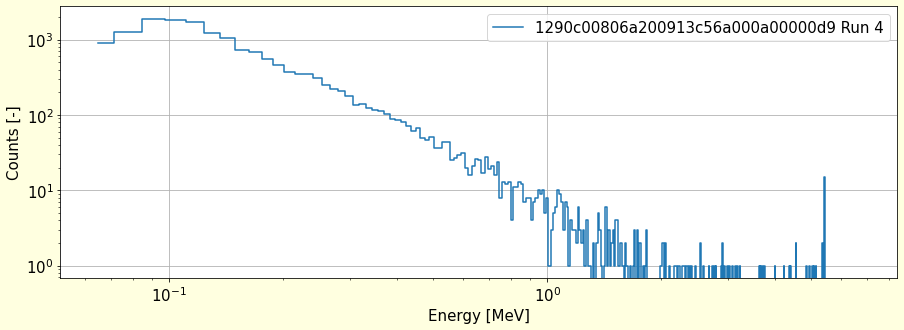

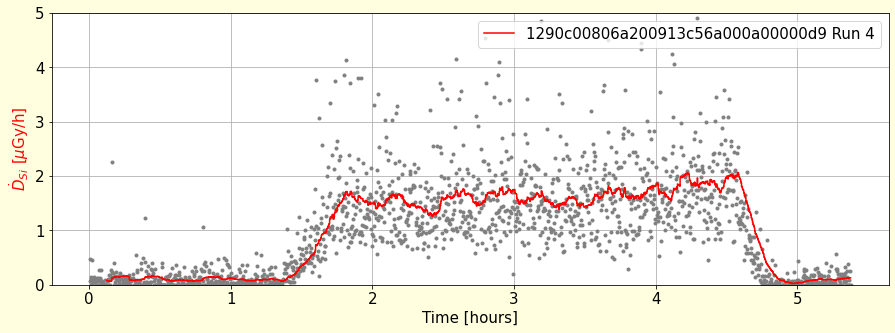

In [175]:
coef = np.array([0.,0.])
coef[1] = CH_WIDTH
coef[0] = CH_WIDTH*(FIRST_CHANNEL-ZERO_CHANNEL+1)
print(coef[0], coef[1])

for r in [SELECTED_RUN]:
    rc = df.loc[df['run']==r].copy()
    rc[2] = pd.to_numeric(rc[2], errors='coerce')

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})

    ener = rc.iloc[:,FIRST_CHANNEL:520].sum()
    
    e = pd.DataFrame()
    e['1'] = ener
    e['i'] = ener.index
    e['x'] = (e['i'].astype(float)-FIRST_CHANNEL) * coef[1] + coef[0]

    plt.plot(e['x'], e['1'], drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Energy [MeV]')
    plt.ylabel('Counts [-]')
    plt.grid()

    plt.legend()
    plt.show()
    
    
    rc['ener'] = (np.asarray(rc.iloc[:,FIRST_CHANNEL:505]) * np.asarray(e['x'][:496])).sum(axis=1)    
    
    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.25 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1165e-3 kg
    
    rc['dsi'] = ((1e6 * (1.602e-19 * rc['ener'] * 1e6)/0.1165e-3)/10) * 3600 # in uGy/h

    rc['dsimean'] = rc['dsi'].rolling(40).mean()

    plt.figure(figsize=(15,5), facecolor='lightyellow')
    matplotlib.rcParams.update({'font.size': 15})
    plt.plot(rc[2]/3600,rc['dsi'], c='gray', linestyle='', marker='.')
    plt.plot(rc[2]/3600,rc['dsimean'],c='red', drawstyle='steps-mid', label=sn+' Run '+str(r))

    plt.ylim([0,5])

    plt.xlabel('Time [hours]')
    plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
    plt.legend(loc=1)

    plt.grid()
    plt.show()


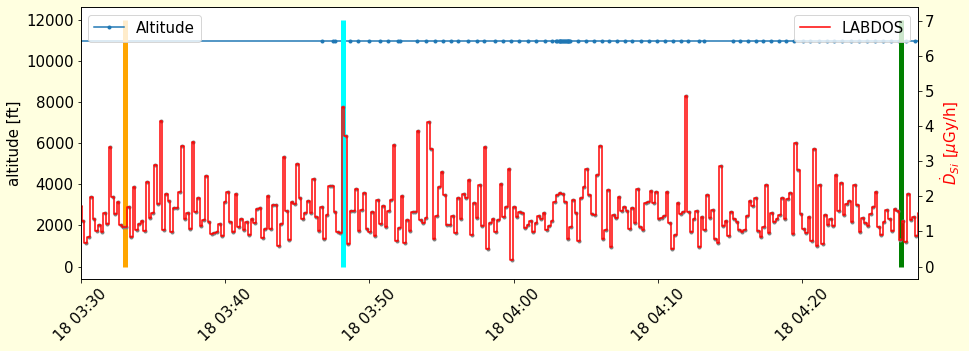

In [176]:
plt.figure(figsize=(15,5), facecolor='lightyellow')

dffr['time']=pd.to_datetime(dffr[1])
dffr = dffr.set_index(dffr['time'])

plt.plot(dffr.iloc[:,4], marker='.', label='Altitude')
plt.ylabel('altitude [ft]')
plt.xticks(rotation=45)
plt.legend(loc=2)

plt.vlines(pd.to_datetime('2024-10-18 03:33:05'),0,12000, lw=5, color='orange')
plt.vlines(pd.to_datetime('2024-10-18 04:26:49'),0,12000, lw=5, color='green')
plt.vlines(pd.to_datetime('2024-10-18 03:48:10'),0,12000, lw=5, color='cyan')

plt.xlim(pd.to_datetime('2024-10-18 03:30:00'),pd.to_datetime('2024-10-18 04:28:00'))

plt.twinx()

rc['time'] = pd.to_datetime('2024-10-18 01:00:30') + pd.to_timedelta(rc.iloc[:,2] - rc.iloc[0,2], 'seconds')
rc.set_index('time', inplace=True, drop=False)

plt.plot(rc['dsi'], c='gray', linestyle='', marker='.')
#rcr = rc.resample('1T').mean()
rcr = rc
plt.plot(rcr['dsi'],c='red', drawstyle='steps-mid', label='LABDOS')
#plt.ylim(0,4)
plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
plt.legend(loc=1)
None

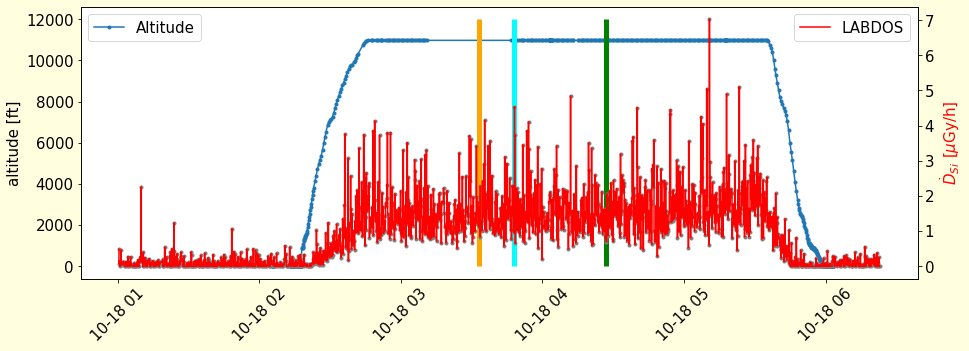

In [177]:
plt.figure(figsize=(15,5), facecolor='lightyellow')

dffr['time']=pd.to_datetime(dffr[1])
dffr = dffr.set_index(dffr['time'])

plt.plot(dffr.iloc[:,4], marker='.', label='Altitude')
plt.ylabel('altitude [ft]')
plt.xticks(rotation=45)
plt.legend(loc=2)

plt.vlines(pd.to_datetime('2024-10-18 03:33:05'),0,12000, lw=5, color='orange')
plt.vlines(pd.to_datetime('2024-10-18 04:26:49'),0,12000, lw=5, color='green')
plt.vlines(pd.to_datetime('2024-10-18 03:48:10'),0,12000, lw=5, color='cyan')

#plt.xlim(pd.to_datetime('2024-10-18 03:30:00'),pd.to_datetime('2024-10-18 04:28:00'))

plt.twinx()

rc['time'] = pd.to_datetime('2024-10-18 01:00:30') + pd.to_timedelta(rc.iloc[:,2] - rc.iloc[0,2], 'seconds')
rc.set_index('time', inplace=True, drop=False)

plt.plot(rc['dsi'], c='gray', linestyle='', marker='.')
#rcr = rc.resample('1T').mean()
rcr = rc
plt.plot(rcr['dsi'],c='red', drawstyle='steps-mid', label='LABDOS')
#plt.ylim(0,4)
plt.ylabel(r'$\.D$$_S$$_i$ [$\mu$Gy/h]', color='red')
plt.legend(loc=1)
None